In [25]:
import os
import pandas as pd
import numpy as np

datapath = "finetune_data3/"
dirs = [
    # 'neutral', 
    'happy', 'sad', 'angry']
# , 'fear', 'disgust']

path_list = []
emotion_list = []

for dir in dirs:
    mood_files = os.listdir(os.path.join(datapath, dir))
    for audio_file in mood_files:
        path_list.append(f"{datapath}{dir}/{audio_file}")
        emotion_list.append(dir)

finetune_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

finetune_df.tail()

df = pd.concat([
    finetune_df
], axis=0, ignore_index=True)
df.tail()

,path,emotion
200,finetune_data3/angry/928989f2964d566454ca37224...,angry
201,finetune_data3/angry/c03241f21383b548e78820c19...,angry
202,finetune_data3/angry/6d00889788eb5dc86bf7516f4...,angry
203,finetune_data3/angry/2bb278d51138ca042dde6b729...,angry
204,finetune_data3/angry/0aad3a076982258c5135201dc...,angry


In [26]:
from pydub import AudioSegment, effects
import librosa

def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    # print(sr)
    padded = np.pad(trimmed, (0, 950000-len(trimmed)), 'constant')
    return padded, sr

emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

In [27]:
zcr_list = []
rms_list = []
mfccs_list = []
tonnetz_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)
        tonnetz_list.append(tonnetz)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")


X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2), 
    # np.swapaxes(tonnetz_list, 1, 2)
    ), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
print(X.shape)
y = np.expand_dims(y, axis=1).astype('int8')

(205, 1856, 15)


In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
import keras
import tensorflow as tf; print(len(tf.config.list_physical_devices('GPU')))

1


In [29]:
X_val = X
y_val = y

y_val_class = to_categorical(y_val, 6)

print(len(X_val), len(y_val_class))

205 205


In [32]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL = keras.saving.load_model("finetuned_model2.keras")

KeyboardInterrupt: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
0.8


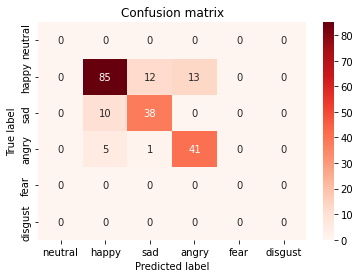

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred) ; print(accuracy)
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()